### Data Preprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


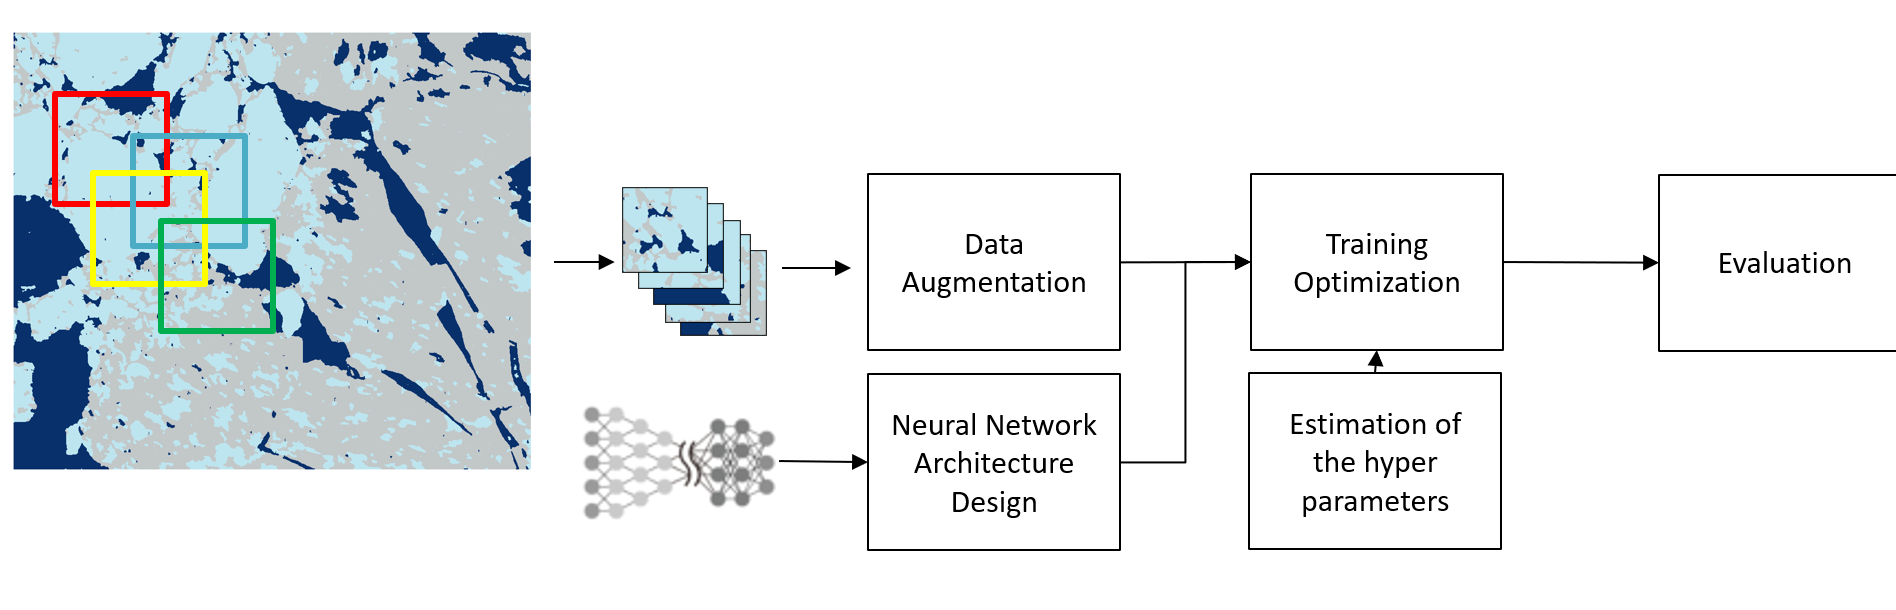

In [ ]:
import numpy as np
import os
import glob

from PIL import Image, ImageOps
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
RNG_SEED = 0
np.random.seed(RNG_SEED)

In [ ]:
def make_dir(output_path):
  if not os.path.isdir(output_path):
    os.mkdir(output_path)

In [ ]:
class ImageSplitter:
  def __init__(self, input_dir):
    self.img_list = glob.glob(f'{input_dir}/image/*')
    self.img_list.sort()
    self.msk_list = glob.glob(f'{input_dir}/mask/*')
    self.msk_list.sort()

  def transform(self, tile_shape, output_path, test_size=.15, val_size=.10):
    make_dir(output_path)
    train_dataset, val_dataset, test_dataset = self.__split_dataset(test_size, val_size)
    self.__process_part(train_dataset, tile_shape, f'{output_path}/train')
    self.__process_part(val_dataset, tile_shape, f'{output_path}/val')
    self.__process_part(test_dataset, tile_shape, f'{output_path}/test')

  def __split_dataset(self, test_size, val_size):
    index_list = list(range(len(self.img_list)))
    first_split_ratio = test_size + val_size
    second_split_ratio = test_size / (test_size + val_size)

    train_dataset, test_val_dataset = train_test_split(index_list, test_size=first_split_ratio, shuffle=True)
    val_dataset, test_dataset = train_test_split(test_val_dataset, test_size=second_split_ratio, shuffle=True)
    return train_dataset, val_dataset, test_dataset

  def __process_part(self, index_list, tile_shape, output_path):
    make_dir(output_path)
    make_dir(f'{output_path}/image')
    make_dir(f'{output_path}/mask')
    for index in tqdm(index_list):
      self.__process_element(index, tile_shape, output_path)

  def __process_element(self, img_index, tile_shape, output_path):
    img = Image.open(self.img_list[img_index]).convert('RGB')
    msk = Image.open(self.msk_list[img_index]).convert('L')

    img, msk = self.__precrop_element(img, msk)
    grid_shape = self.__get_grid_shape(img, tile_shape)
    img = self.__pad_image(img, grid_shape, tile_shape)
    msk = self.__pad_image(msk, grid_shape, tile_shape)

    img = np.array(img)
    msk = np.array(msk)
    self.__process_image(img, grid_shape, tile_shape, img_index, f'{output_path}/image')
    self.__process_image(msk, grid_shape, tile_shape, img_index, f'{output_path}/mask')

  def __precrop_element(self, img, msk):
    bbox = img.getbbox()
    img = img.crop(box=bbox)
    msk = msk.crop(box=bbox)
    return img, msk

  def __get_grid_shape(self, image, tile_shape):
    x_count = (image.size[0] - 1) // tile_shape[0] + 1
    y_count = (image.size[1] - 1) // tile_shape[1] + 1
    return (x_count, y_count)

  def __pad_image(self, image, grid_shape, tile_shape):
    x_size = grid_shape[0] * tile_shape[0]
    y_size = grid_shape[1] * tile_shape[1]
    target_size = (x_size, y_size)
    return ImageOps.pad(image, size=target_size)

  def __process_image(
      self,
      image,
      grid_shape, tile_shape,
      img_index,
      output_directory
  ):
    for x in range(grid_shape[0]):
      for y in range(grid_shape[1]):
        self.__process_square(image, (x, y), tile_shape, img_index, output_directory)

  def __process_square(
      self,
      image,
      grid_coord, tile_shape,
      img_index,
      output_directory
  ):
    x_index = grid_coord[0]
    y_index = grid_coord[1]
    x = x_index * tile_shape[0]
    y = y_index * tile_shape[1]
    tile = image[y:y+tile_shape[1],x:x+tile_shape[0]]
    tile = Image.fromarray(tile)
    tile.save(f'{output_directory}/{img_index:02d}_{x_index:03d}_{y_index:03d}.tif')

In [ ]:
BASE_FOLDER = '/content/gdrive/MyDrive/semanticSegmentation'
INPUT_DIR = f'{BASE_FOLDER}/original'
TILE_SHAPE = (256,256)

OUTPUT_BASE = '/tmp/semanticSegmentation'
make_dir(OUTPUT_BASE)
OUTPUT_DIR = f'{OUTPUT_BASE}/{TILE_SHAPE[0]}x{TILE_SHAPE[1]}'

splitter = ImageSplitter(INPUT_DIR)
splitter.transform(TILE_SHAPE, OUTPUT_DIR)

### Model Training


In [ ]:
!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install --upgrade --force-reinstall --no-deps tensorboard

!pip install -q pytorch-lightning
!pip install -q torch_tb_profiler
!pip install -q torchmetrics

     |████████████████████████████████| 98 kB 6.3 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 6.0 MB 8.0 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
     |████████████████████████████████| 915 kB 6.4 MB/s 
     |████████████████████████████████| 636 kB 23.5 MB/s 
     |████████████████████████████████| 118 kB 29.1 MB/s 
     |████████████████████████████████| 10.6 MB 24.0 MB/s 
     |████████████████████████████████| 829 kB 55.1 MB/s 
     |████████████████████████████████| 234 kB 60.0 MB/s 
     |████████████████████████████████| 1.3 MB 60.8 MB/s 
     |████████████████████████████████| 142 kB 65.6 MB/s 
     |████████████████████████████████| 294 kB 61.3 MB/s 
ERROR:

In [ ]:
from tqdm.notebook import tqdm
from PIL import Image, ImageOps

import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import models, transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, IoU, ConfusionMatrix

In [ ]:
RNG_SEED = 0
pl.seed_everything(RNG_SEED)

Global seed set to 0


0

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device.type

'cuda'

In [ ]:
BASE_FOLDER = '/tmp/semanticSegmentation'
DATASET_DIR = f'{BASE_FOLDER}/256x256'

In [ ]:
class SegDataset(torch.utils.data.Dataset):
  def __init__(self, dataset_dir, transform=None):
    self.img_list = glob.glob(f'{dataset_dir}/image/*')
    self.img_list.sort()
    self.msk_list = glob.glob(f'{dataset_dir}/mask/*')
    self.msk_list.sort()
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(self.img_list[index]).convert('RGB')
    msk = Image.open(self.msk_list[index]).convert('L')
    img = np.array(img)
    msk = np.array(msk)
    if self.transform is not None:
      transformed = self.transform(image=img, mask=msk)
      img = transformed["image"]
      msk = transformed["mask"]
    msk = msk.long()
    return {'image': img, 'mask': msk}

  def __len__(self):
    return len(self.img_list)

In [ ]:
transform_train = A.Compose(
  [
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
  ]
)

dataset_train = SegDataset(f'{DATASET_DIR}/train', transform_train)
len(dataset_train)

0

In [ ]:
transform_val = A.Compose(
  [
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
  ]
)
dataset_val = SegDataset(f'{DATASET_DIR}/val', transform_val)
len(dataset_val)

0

In [ ]:
CLASS_COUNT = 6


class CustomTransformerClassfier(pl.LightningModule):
  def __init__(self, num_labels, learning_rate):
    super(CustomTransformerClassfier, self).__init__()
    self.classier = self.__fetch_model(num_labels)
    self.softmax = torch.nn.LogSoftmax(dim=1)
    self.learning_rate = learning_rate

    self.train_metrics = MetricCollection([
      Accuracy(num_classes=num_labels, average='micro', mdmc_average='global'),
      F1(num_classes=num_labels, average='micro', mdmc_average='global'),
    ], prefix='train_')                                  
    self.valid_metrics = MetricCollection([
      Accuracy(num_classes=num_labels, average='micro', mdmc_average='global'),
      Precision(num_classes=num_labels, average='micro', mdmc_average='global'),
      Recall(num_classes=num_labels, average='micro', mdmc_average='global'),
      F1(num_classes=num_labels, average='micro', mdmc_average='global'),
      IoU(num_classes=num_labels)
    ], prefix='val_')

  def __fetch_model(self, num_classes):
    return models.segmentation.deeplabv3_resnet101(
      pretrained=False,
      progress=True, 
      num_classes=num_classes
    )
  
  def forward(self, batch):
    outputs = self.classier(batch['image'])
    logits = outputs['out']
    probs = self.softmax(logits)
    return probs

  def get_cross_entropy_loss(self, logits, labels):
    loss = torch.nn.NLLLoss()
    return loss(logits, labels)

  def training_step(self, batch, batch_idx):
    labels = batch['mask']
    logits = self(batch)
    batch_loss = self.get_cross_entropy_loss(logits, labels)

    metrics = self.train_metrics(logits, labels)
    self.log_dict(metrics)

    self.log('train_loss', batch_loss)
    return batch_loss

  def validation_step(self, batch, batch_idx):
    labels = batch['mask']
    logits = self(batch)
    batch_loss = self.get_cross_entropy_loss(logits, labels)

    self.log('val_loss', batch_loss)
    return {'loss' : batch_loss, 'preds' : logits, 'target' : labels}

  def validation_step_end(self, outputs):
    metrics = self.valid_metrics(outputs['preds'], outputs['target'])
    self.log_dict(metrics)

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
    return optimizer

In [ ]:
CLASS_COUNT = 6
LEARNING_RATE = 5e-5
EPOCH_COUNT = 10
BATCH_SIZE = 16

In [ ]:
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

ValueError: ignored

In [ ]:
model = CustomTransformerClassfier(
    num_labels=CLASS_COUNT,
    learning_rate=LEARNING_RATE
)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


In [ ]:
DRIVE_FOLDER = '/content/gdrive/MyDrive/semanticSegmentation/pytorch'

checkpoint_callback = ModelCheckpoint(
  monitor='val_loss',
  dirpath=DRIVE_FOLDER+'/ice_classfier/',
  filename='ice-classfier-{epoch:02d}-{val_loss:.2f}',
  save_top_k=-1
)
tb_logger = TensorBoardLogger(DRIVE_FOLDER + '/lightning_logs/')

trainer = Trainer(
    gpus=1,
    max_epochs=EPOCH_COUNT,
    deterministic=True,
    callbacks=[checkpoint_callback],
    logger=tb_logger,
    profiler='simple'
)
trainer.fit(model, loader_train, loader_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | classier      | DeepLabV3        | 58.6 M
1 | softmax       | LogSoftmax       | 0     
2 | train_metrics | MetricCollection | 0     
3 | valid_metrics | MetricCollection | 0     
---------------------------------------------------
58.6 M    Trainable params
0         Non-trainable params
58.6 M    Total params
234.509   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Global seed set to 0


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/gdrive/MyDrive/semanticSegmentation/pytorch/lightning_logs/

### Model Evaluation

In [ ]:
CLASS_COUNT = 6
LEARNING_RATE = 5e-5
EPOCH_COUNT = 10
BATCH_SIZE = 16

In [ ]:
BASE_FOLDER = '/content/gdrive/MyDrive/semanticSegmentation'
MODEL_DIR_PATH = f'{BASE_FOLDER}/models/'
MODEL_NAME = 'ice-classfier-epoch=15-val_loss=0.12.ckpt'
MODEL_PATH = MODEL_DIR_PATH + MODEL_NAME

model = CustomTransformerClassfier.load_from_checkpoint(
  MODEL_PATH,
  num_labels=CLASS_COUNT,
  learning_rate=LEARNING_RATE
)

NameError: ignored

In [ ]:
class MergerSegDataset(torch.utils.data.Dataset):
  def __init__(self, input_dir, img_list, transform=None):
    self.input_dir = input_dir
    self.img_list = img_list
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(f'{self.input_dir}/image/{self.img_list[index]}.tif').convert('RGB')
    msk = Image.open(f'{self.input_dir}/mask/{self.img_list[index]}.tif').convert('L')
    img = np.array(img)
    msk = np.array(msk)
    if self.transform is not None:
      transformed = self.transform(image=img, mask=msk)
      img = transformed["image"]
      msk = transformed["mask"]
    return {'image': img, 'mask': msk}

  def __len__(self):
    return len(self.img_list)

In [ ]:
def get_predictions(trainer, model, data_loader):
  logits = trainer.predict(model, data_loader)
  logits = [batch.cpu().detach().numpy() for batch in logits]
  logits = np.vstack(logits)
  preds = np.argmax(logits, axis=1)

  masks = [batch['mask'] for batch in data_loader]
  masks = np.vstack(masks)
  return masks, preds

In [ ]:
def predict_tiles(input_dir, img_list):
  dataset_pred = MergerSegDataset(input_dir, img_list, transform_val)
  loader_pred = DataLoader(dataset_pred, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
  trainer = Trainer(gpus=1, deterministic=True)
  return get_predictions(trainer, model, loader_pred)

In [ ]:
class ImageMerger:
  def __init__(self, input_dir):
    file_paths = glob.glob(f'{input_dir}/image/*')
    img_df = self.__process_filepaths(file_paths)
    self.input_dir = input_dir
    self.img_df_list = [e[1] for e in list(img_df.groupby(['img_index']))]

  def __process_filepaths(self, file_paths):
    parts_list = [self.__process_filepath(file_path) for file_path in file_paths]
    return pd.DataFrame(parts_list, columns=['rootname', 'img_index', 'x_index', 'y_index'])

  def __process_filepath(self, filepath):
    basename = os.path.basename(filepath)
    root = os.path.splitext(basename)[0]
    indexes = [int(index) for index in root.split("_")]
    return [root] + indexes

  def transform(self, predict_fn, tile_shape, output_directory):
    for img_df in tqdm(self.img_df_list):
      self.__process_image(img_df, tile_shape, output_directory)
      self.__process_mask_pred(img_df, predict_fn, tile_shape, output_directory)

  def __process_image(self, img_df, tile_shape, output_directory):
    img_df = img_df.sort_values(by=['x_index', 'y_index'])
    img_index = img_df['img_index'].iloc[0]
    grid_shape = self.__get_grid_shape(img_df)

    img = MergerSegDataset(self.input_dir, list(img_df['rootname']))
    img = self.__process_tile(img, grid_shape, tile_shape)
    self.__save_image(img, output_directory, img_index, 'img')

  def __process_tile(self, img_list, grid_shape, tile_shape):
    grid_size = self.__get_grid_size(grid_shape, tile_shape)
    img_arr = np.zeros(shape=(grid_size[1], grid_size[0], 3))
    for x_index in range(grid_shape[0]):
      for y_index in range(grid_shape[1]):
        grid_coords = (x_index, y_index)
        x = x_index * tile_shape[0]
        y = y_index * tile_shape[1]
        df_index = grid_coords[0] * grid_shape[1] + grid_coords[1]
        img_arr[y:y+tile_shape[1],x:x+tile_shape[0]] = img_list[df_index]['image']
    return img_arr

  def __process_mask_pred(self, img_df, predict_fn, tile_shape, output_directory):
    img_df = img_df.sort_values(by=['x_index', 'y_index'])
    img_index = img_df['img_index'].iloc[0]
    grid_shape = self.__get_grid_shape(img_df)

    msk, prd = predict_fn(self.input_dir, list(img_df['rootname']))
    msk = self.__process_part(msk, grid_shape, tile_shape)
    self.__save_image(msk, output_directory, img_index, 'msk')
    prd = self.__process_part(prd, grid_shape, tile_shape)
    self.__save_image(prd, output_directory, img_index, 'prd')

  def __process_part(self, img_list, grid_shape, tile_shape):
    grid_size = self.__get_grid_size(grid_shape, tile_shape)
    img_arr = np.zeros(shape=(grid_size[1], grid_size[0]))
    for x_index in range(grid_shape[0]):
      for y_index in range(grid_shape[1]):
        grid_coords = (x_index, y_index)
        x = x_index * tile_shape[0]
        y = y_index * tile_shape[1]
        df_index = grid_coords[0] * grid_shape[1] + grid_coords[1]
        img_arr[y:y+tile_shape[1],x:x+tile_shape[0]] = img_list[df_index]
    return img_arr

  def __get_grid_shape(self, img_df):
    x_count = img_df['x_index'].max() + 1
    y_count = img_df['y_index'].max() + 1
    return (x_count, y_count)

  def __get_grid_size(self, grid_shape, tile_shape):
    x_size = (grid_shape[0] + 1) * tile_shape[0]
    y_size = (grid_shape[1] + 1) * tile_shape[1]
    return (x_size, y_size)

  def __save_image(self, img_arr, output_directory, img_index, img_suffix):
    img = Image.fromarray(img_arr.astype(np.uint8))
    img.save(f'{output_directory}/{img_index:02d}_{img_suffix}.tif')

In [ ]:
DATASET_DIR = '/tmp/semanticSegmentation/256x256'
OUTPUT_DIR = '/tmp'

image_merger = ImageMerger(f'{DATASET_DIR}/test')
image_merger.transform(predict_tiles, tile_shape=(256,256), output_directory=OUTPUT_DIR)

In [ ]:
def show_prediction_with_mask(file_path):
  cmap = ListedColormap(["white","#bedbe2","#c0c6c7","#3281bc", "#08306b"], name='from_list', N=None)
  plt.figure(figsize=(8, 6), dpi=80)

  img = Image.open(f'{file_path}_img.tif').convert('RGB')
  img = np.array(img)
  ax = plt.subplot(1, 3, 1)
  ax.imshow(img)
  ax.set_title('image')
  
  msk = Image.open(f'{file_path}_msk.tif').convert('L')
  msk = np.array(msk)
  ax = plt.subplot(1, 3, 2)
  ax.imshow(msk, cmap=cmap)
  ax.set_title('mask')

  prd = Image.open(f'{file_path}_prd.tif').convert('L')
  prd = np.array(prd)
  ax = plt.subplot(1, 3, 3)
  ax.imshow(prd, cmap=cmap)
  ax.set_title('prediction')

  plt.tight_layout()

In [ ]:
show_prediction_with_mask(f'{OUTPUT_DIR}/08')

In [ ]:
show_prediction_with_mask(f'{OUTPUT_DIR}/10')

In [ ]:
show_prediction_with_mask(f'{OUTPUT_DIR}/19')

### Model Evaluation - part 2

In [ ]:
CLASS_COUNT = 6
LEARNING_RATE = 5e-5
EPOCH_COUNT = 10
BATCH_SIZE = 16

In [ ]:
BASE_FOLDER = '/content/gdrive/MyDrive/semanticSegmentation'
MODEL_DIR_PATH = f'{BASE_FOLDER}/models/'
MODEL_NAME = 'model.ckpt'
MODEL_PATH = MODEL_DIR_PATH + MODEL_NAME

model = CustomTransformerClassfier.load_from_checkpoint(
  MODEL_PATH,
  num_labels=CLASS_COUNT,
  learning_rate=LEARNING_RATE
)

RuntimeError: ignored

In [ ]:
class EvalImageSplitter:
  def __init__(self, input_dir):
    self.img_list = glob.glob(f'{input_dir}/*')
    self.img_list.sort()

  def transform(self, tile_shape, output_path):
    make_dir(output_path)
    self.__process_part(range(len(self.img_list)), tile_shape, output_path)

  def __process_part(self, index_list, tile_shape, output_path):
    make_dir(output_path)
    for index in tqdm(index_list):
      self.__process_element(index, tile_shape, output_path)

  def __process_element(self, img_index, tile_shape, output_path):
    img = Image.open(self.img_list[img_index]).convert('RGB')

    img = self.__precrop_element(img)
    grid_shape = self.__get_grid_shape(img, tile_shape)
    img = self.__pad_image(img, grid_shape, tile_shape)

    img = np.array(img)
    self.__process_image(img, grid_shape, tile_shape, img_index, output_path)

  def __precrop_element(self, img):
    bbox = img.getbbox()
    return img.crop(box=bbox)

  def __get_grid_shape(self, image, tile_shape):
    x_count = (image.size[0] - 1) // tile_shape[0] + 1
    y_count = (image.size[1] - 1) // tile_shape[1] + 1
    return (x_count, y_count)

  def __pad_image(self, image, grid_shape, tile_shape):
    x_size = grid_shape[0] * tile_shape[0]
    y_size = grid_shape[1] * tile_shape[1]
    target_size = (x_size, y_size)
    return ImageOps.pad(image, size=target_size)

  def __process_image(
      self,
      image,
      grid_shape, tile_shape,
      img_index,
      output_directory
  ):
    for x in range(grid_shape[0]):
      for y in range(grid_shape[1]):
        self.__process_square(image, (x, y), tile_shape, img_index, output_directory)

  def __process_square(
      self,
      image,
      grid_coord, tile_shape,
      img_index,
      output_directory
  ):
    x_index = grid_coord[0]
    y_index = grid_coord[1]
    x = x_index * tile_shape[0]
    y = y_index * tile_shape[1]
    tile = image[y:y+tile_shape[1],x:x+tile_shape[0]]
    tile = Image.fromarray(tile)
    tile.save(f'{output_directory}/{img_index:02d}_{x_index:03d}_{y_index:03d}.tif')

In [ ]:
BASE_FOLDER = '/content/gdrive/MyDrive/semanticSegmentation'
INPUT_DIR = f'{BASE_FOLDER}/badlight_photos'
TILE_SHAPE = (256,256)

OUTPUT_BASE = '/tmp/semanticSegmentationBadLight'
make_dir(OUTPUT_BASE)
OUTPUT_DIR = f'{OUTPUT_BASE}/{TILE_SHAPE[0]}x{TILE_SHAPE[1]}'

splitter = EvalImageSplitter(INPUT_DIR)
splitter.transform(TILE_SHAPE, OUTPUT_DIR)

In [ ]:
class EvalSegDataset(torch.utils.data.Dataset):
  def __init__(self, input_dir, img_list, transform=None):
    self.input_dir = input_dir
    self.img_list = img_list
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(f'{self.input_dir}/{self.img_list[index]}.tif').convert('RGB')
    img = np.array(img)
    if self.transform is not None:
      transformed = self.transform(image=img)
      img = transformed["image"]
    return {'image': img}

  def __len__(self):
    return len(self.img_list)

In [ ]:
def get_predictions(trainer, model, data_loader):
  logits = trainer.predict(model, data_loader)
  logits = [batch.cpu().detach().numpy() for batch in logits]
  logits = np.vstack(logits)
  preds = np.argmax(logits, axis=1)
  return preds

In [ ]:
transform_val = A.Compose(
  [
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
  ]
)

def predict_tiles(input_dir, img_list):
  dataset_pred = EvalSegDataset(input_dir, img_list, transform_val)
  loader_pred = DataLoader(dataset_pred, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
  trainer = Trainer(gpus=1, deterministic=True)
  return get_predictions(trainer, model, loader_pred)

In [ ]:
class EvalImageMerger:
  def __init__(self, input_dir):
    file_paths = glob.glob(f'{input_dir}/*')
    img_df = self.__process_filepaths(file_paths)
    self.input_dir = input_dir
    self.img_df_list = [e[1] for e in list(img_df.groupby(['img_index']))]

  def __process_filepaths(self, file_paths):
    parts_list = [self.__process_filepath(file_path) for file_path in file_paths]
    return pd.DataFrame(parts_list, columns=['rootname', 'img_index', 'x_index', 'y_index'])

  def __process_filepath(self, filepath):
    basename = os.path.basename(filepath)
    root = os.path.splitext(basename)[0]
    indexes = [int(index) for index in root.split("_")]
    return [root] + indexes

  def transform(self, predict_fn, tile_shape, output_directory):
    for img_df in tqdm(self.img_df_list):
      self.__process_image(img_df, tile_shape, output_directory)
      self.__process_pred(img_df, predict_fn, tile_shape, output_directory)

  def __process_image(self, img_df, tile_shape, output_directory):
    img_df = img_df.sort_values(by=['x_index', 'y_index'])
    img_index = img_df['img_index'].iloc[0]
    grid_shape = self.__get_grid_shape(img_df)

    img = EvalSegDataset(self.input_dir, list(img_df['rootname']))
    img = self.__process_tile(img, grid_shape, tile_shape)
    self.__save_image(img, output_directory, img_index, 'img')

  def __process_tile(self, img_list, grid_shape, tile_shape):
    grid_size = self.__get_grid_size(grid_shape, tile_shape)
    img_arr = np.zeros(shape=(grid_size[1], grid_size[0], 3))
    for x_index in range(grid_shape[0]):
      for y_index in range(grid_shape[1]):
        grid_coords = (x_index, y_index)
        x = x_index * tile_shape[0]
        y = y_index * tile_shape[1]
        df_index = grid_coords[0] * grid_shape[1] + grid_coords[1]
        img_arr[y:y+tile_shape[1],x:x+tile_shape[0]] = img_list[df_index]['image']
    return img_arr

  def __process_pred(self, img_df, predict_fn, tile_shape, output_directory):
    img_df = img_df.sort_values(by=['x_index', 'y_index'])
    img_index = img_df['img_index'].iloc[0]
    grid_shape = self.__get_grid_shape(img_df)

    prd = predict_fn(self.input_dir, list(img_df['rootname']))
    prd = self.__process_part(prd, grid_shape, tile_shape)
    self.__save_image(prd, output_directory, img_index, 'prd')

  def __process_part(self, img_list, grid_shape, tile_shape):
    grid_size = self.__get_grid_size(grid_shape, tile_shape)
    img_arr = np.zeros(shape=(grid_size[1], grid_size[0]))
    for x_index in range(grid_shape[0]):
      for y_index in range(grid_shape[1]):
        grid_coords = (x_index, y_index)
        x = x_index * tile_shape[0]
        y = y_index * tile_shape[1]
        df_index = grid_coords[0] * grid_shape[1] + grid_coords[1]
        img_arr[y:y+tile_shape[1],x:x+tile_shape[0]] = img_list[df_index]
    return img_arr

  def __get_grid_shape(self, img_df):
    x_count = img_df['x_index'].max() + 1
    y_count = img_df['y_index'].max() + 1
    return (x_count, y_count)

  def __get_grid_size(self, grid_shape, tile_shape):
    x_size = (grid_shape[0] + 1) * tile_shape[0]
    y_size = (grid_shape[1] + 1) * tile_shape[1]
    return (x_size, y_size)

  def __save_image(self, img_arr, output_directory, img_index, img_suffix):
    img = Image.fromarray(img_arr.astype(np.uint8))
    img.save(f'{output_directory}/{img_index:02d}_{img_suffix}.tif')

In [ ]:
DATASET_DIR = '/tmp/semanticSegmentationBadLight/256x256'
OUTPUT_DIR = '/tmp/semanticSegmentationBadLight_output'

image_merger = EvalImageMerger(DATASET_DIR)
make_dir(OUTPUT_DIR)
image_merger.transform(predict_tiles, tile_shape=(256,256), output_directory=OUTPUT_DIR)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


NameError: ignored

In [ ]:
def show_prediction(file_path):
  cmap = ListedColormap(["white","#bedbe2","#c0c6c7","#3281bc", "#08306b"], name='from_list', N=None)
  plt.figure(figsize=(8, 6), dpi=80)

  img = Image.open(f'{file_path}_img.tif').convert('RGB')
  img = np.array(img)
  ax = plt.subplot(1, 2, 1)
  ax.imshow(img)
  ax.set_title('image')
  
  prd = Image.open(f'{file_path}_prd.tif').convert('L')
  prd = np.array(prd)
  ax = plt.subplot(1, 2, 2)
  ax.imshow(prd, cmap=cmap)
  ax.set_title('prediction')

  plt.tight_layout()

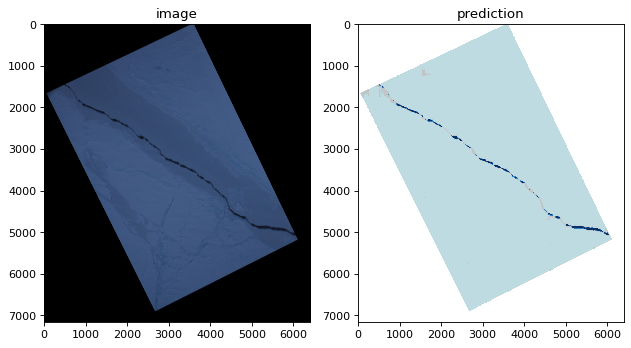

In [ ]:
show_prediction(f'{OUTPUT_DIR}/00')

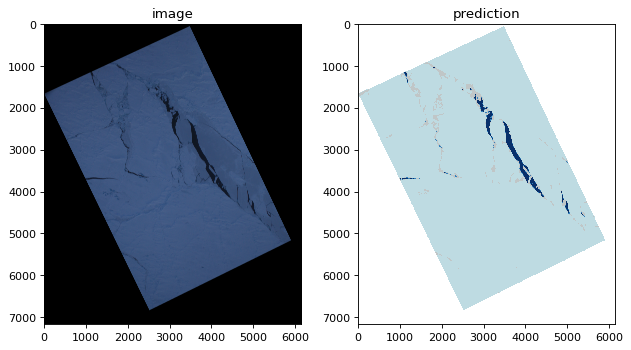

In [ ]:
show_prediction(f'{OUTPUT_DIR}/01')

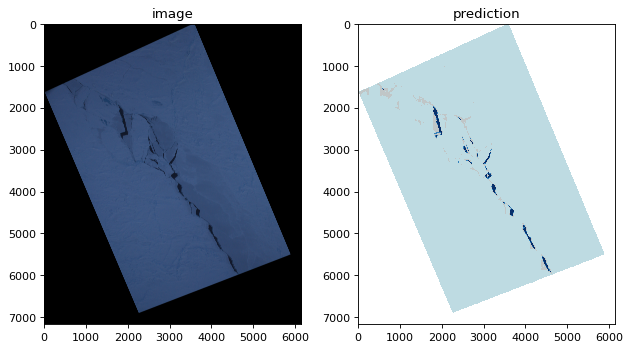

In [ ]:
show_prediction(f'{OUTPUT_DIR}/02')

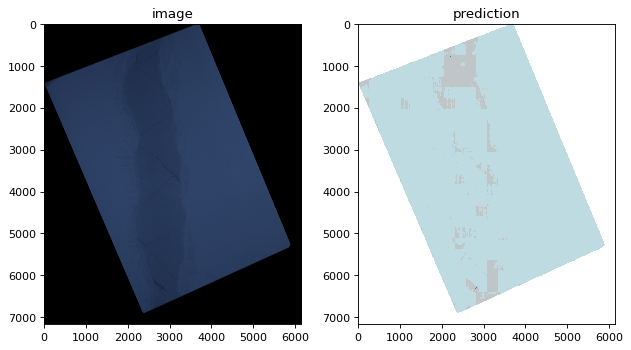

In [ ]:
show_prediction(f'{OUTPUT_DIR}/03')

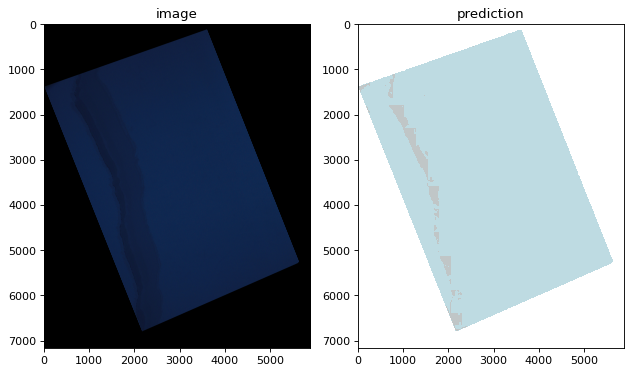

In [ ]:
show_prediction(f'{OUTPUT_DIR}/04')

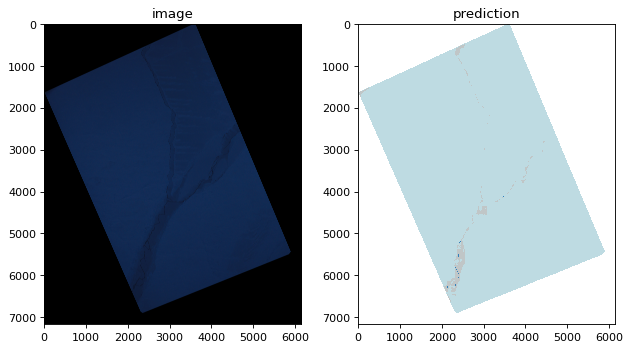

In [ ]:
show_prediction(f'{OUTPUT_DIR}/05')

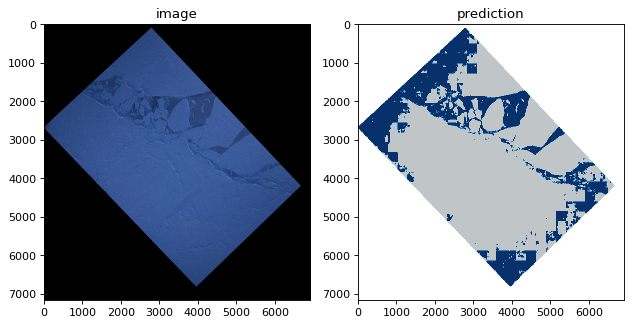

In [ ]:
show_prediction(f'{OUTPUT_DIR}/06')

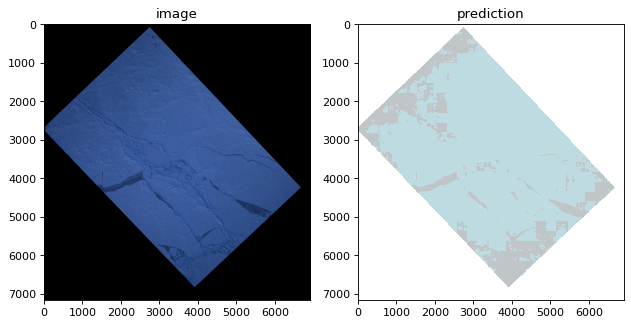

In [ ]:
show_prediction(f'{OUTPUT_DIR}/07')

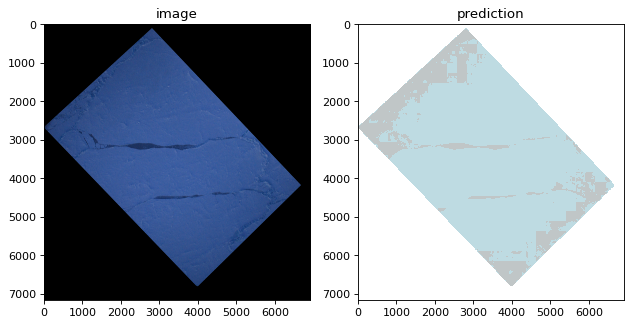

In [ ]:
show_prediction(f'{OUTPUT_DIR}/08')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/09')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/10')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/11')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/12')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/13')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/14')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/15')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/16')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/17')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/18')

In [ ]:
show_prediction(f'{OUTPUT_DIR}/19')